<a href="https://colab.research.google.com/github/JunTu-XD/EmbeddingBleu/blob/main/Embedding_Bleu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset
dataframe: df [
ref
sys
mqm
bleu]


In [1]:
import pandas as pd
from google.colab import drive
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/CL_ESSENTIALS/mqm_newstest2021_zhen.tsv', sep='\t', quoting = 2)

with open('/content/drive/MyDrive/CL_ESSENTIALS/mqm_newstest2021_zhen.tsv') as f:
  contents = f.read()
  contents = contents.replace("”", '')
  contents = contents.replace('"', '')

data = pd.read_csv(StringIO(contents), sep='\t')
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,system,doc,doc_id,seg_id,rater,source,target,category,severity
0,hyp.Borderline,chinanews.com.229454,1,1644,rater8,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Locale convention/Address format,Major
1,hyp.DIDI-NLP,chinanews.com.229454,1,1644,rater9,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,<v>On</v> the afternoon of the 25th local time...,Fluency/Grammar,Major
2,hyp.DIDI-NLP,chinanews.com.229454,1,1644,rater9,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Accuracy/Addition,Major
3,hyp.Facebook-AI,chinanews.com.229454,1,1644,rater2,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a sma...",Accuracy/Mistranslation,Minor
4,hyp.IIE-MT,chinanews.com.229454,1,1644,rater3,当地时间25日下午，一架小型飞机在德国北威州韦瑟尔县撞上一座多层住宅楼的顶层，事故共造成三人死亡。,"On the afternoon of the 25th local time, a <v>...",Terminology/Inappropriate for context,Major
...,...,...,...,...,...,...,...,...,...
17216,hyp.metricsystem5,xinhua-zh-01.120586,12,259,rater1,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,Foods that have the effect of clearing heat an...,Style/Awkward,Minor
17217,ref.A,xinhua-zh-01.120586,12,259,rater1,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"Therefore, mung beans and coix seeds should be...",Accuracy/Mistranslation,Major
17218,ref.B,xinhua-zh-01.120586,12,259,rater2,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"People may choose mung beans, Job's tears, and...",Accuracy/Mistranslation,Minor
17219,ref.B,xinhua-zh-01.120586,12,259,rater2,饮食上可选择绿豆、薏仁等具有清热解暑、健脾开胃作用的食物，以及苦菜、苦瓜等苦味食物，可有助于...,"People may choose mung beans, Job's tears, and...",Fluency/Punctuation,Minor


One error in a segment is recoreded in one line in the data file. To ccollect all errors associated with the same segment, we have to accumulate them.

We use ref-B as the ground truth because it has a better MQM score.


In [2]:
# Helper functions

def clean_mqm_viewer_annotations(input: str) -> str:
  # Rmove MQM viewer tags
  output = input.replace("<v>", "")
  output = output.replace("</v>", "")
  return output

def mqm_score(category: str, severity: str) -> float:
  if category == severity == "No-error":
    return 0
  
  if category == "Non-translation":
    return 25
  
  if severity == "Minor":
    if category == "Fluency/Punctuation":
      return 0.1
    else:
      return 1
  elif severity == "Major":
    return 5
  else:
    raise Exception(f"Unexpected MQM evaluation severity: {severity}")

In [3]:
# Collect ref-B translations in a hashmap (seg_id -> target)
refs = {}

for i in data.index:
  if data['system'][i] == "ref.B":
    refs[data['seg_id'][i]] = clean_mqm_viewer_annotations(data['target'][i])

len(refs)

650

In [4]:
from nltk.translate.bleu_score import corpus_bleu

# Collect translations from all systems, accumulate their MQM scores, 
# calculate their BLEU scores and match the reference translation
translations = {}

for i in data.index:
  if data['system'][i] == "ref.A" or data['system'][i] == "ref.B":
    # Skip references - we only look for translations
    continue

  if data['seg_id'][i] not in refs:
    # We don't have a reference for this translation
    continue

  ref = refs[data['seg_id'][i]]
  system = clean_mqm_viewer_annotations(data['target'][i])

  key = (data['system'][i], data['seg_id'][i])
  if key not in translations:
    translations[key] = {
        "ref": ref,
        "sys": system,
        "mqm": 0,
        "bleu": 0.0,
    }

    # Calculate BLEU score for ref vs sys
    bleu = corpus_bleu([[ref]], [system])
    translations[key]["bleu"] = bleu

  # Accumulate MQM score for this translation
  mqm = mqm_score(data['category'][i], data['severity'][i])
  translations[key]["mqm"] += mqm

len(translations)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

8450

In [5]:
import torch
import numpy as np
df = pd.DataFrame.from_dict(translations.values())

max_len = len(max(df['ref'], key=len))+1

ref = []
sys = []
bleu_data = []
mqm_data =[]
for i in range(len(df['ref'])):
    if max_len > len(df['ref'][i]) and max_len > len(df['sys'][i]):
        ref.append(df['ref'][i])
        sys.append(df['sys'][i])
        bleu_data.append(df['bleu'][i])
        mqm_data.append(df['mqm'][i])

# assume A is 1d
def normalize(func, A, **args):
    if func == "scaling_range":
        return (torch.tensor(A)- args['range_min']) / (args['range_max']- args['range_min'])

idx = np.random.permutation(len(ref))

ref = np.asarray(ref)[idx].tolist()
sys = np.asarray(sys)[idx].tolist()
bleu_data =(np.asarray(bleu_data))[idx].tolist()
mqm_data =np.asarray(mqm_data)[idx].tolist()


mqm_data = torch.tensor(mqm_data)
mqm_data = 25-mqm_data
mqm_data = normalize("scaling_range", mqm_data, range_min=0,range_max=25).tolist()
mqm_data[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


1.0

### Randonly Word Disorder 

In [6]:
## random seq words order
seed = 23
np.random.seed(23)
def random_disorder(seqs, labels, cnt,  swap_dist, label_penality, disorder_percentage=0.5):
    rdn_seqs = []
    rdn_labels = []
    for seq_id, seq in enumerate(seqs):
        lst = seq.split(" ")
        rdn_if = np.random.uniform(0,1)
        if (len(lst)<=swap_dist or rdn_if > disorder_percentage):
            # print(seq_id)
            # print(seq)
            rdn_labels.append(labels[seq_id])            
            rdn_seqs.append(seq)
            continue
        for i in range(cnt):
            indx = np.random.randint(0, len(lst)-swap_dist)
            lst[indx], lst[swap_dist+indx] = lst[swap_dist+indx], lst[indx]

        rdn_labels.append(labels[seq_id]-label_penality)
        rdn_seqs.append(' '.join(lst))
    return rdn_seqs,labels

random_disorder(sys[35:38], mqm_data[35:38], cnt=2, swap_dist=3, label_penality=0.04)

(['It is reported that the addition of the nuclear bomb element in the second part also makes the challenge faced by the bomb disposal experts more difficult. The few startling shots in the forecast have made people hang on the line. The mushroom cloud of the big bang, the airport engulfed by the fire, the scene is quite shocking.',
  'All participants can enter the parliament building after passing a quick test on the same day.',
  'Sports leader Zhang Jike and sports assistant Lin Xiaozhai cross-border on the same stage. Lin Dan and Fu Yuanhui commented on their own styles, and the hard core of the “colossal force pulling device made the show more “burning.'],
 [0.0, 1.0, 0.6000000238418579])

### distribution of MQM score

Text(0.5, 1.0, 'MQM data distribution')

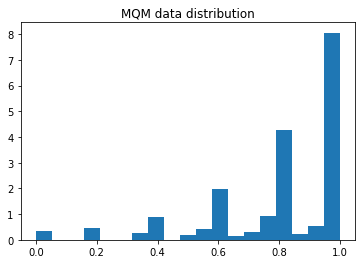

In [7]:
plt.figure("11")
plt.hist(mqm_data, bins=np.linspace(0,1, 20), density=True)
plt.title("MQM data distribution")

## Word Embedding

## Sequence Embedding
https://www.sbert.net/examples/applications/computing-embeddings/README.html

Ref:https://arxiv.org/abs/1908.10084


In [8]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
from sentence_transformers import SentenceTransformer, util
import pickle
import torch
# seq_pretrained_model = SentenceTransformer('all-mpnet-base-v2', device='cuda')
seq_pretrained_model = SentenceTransformer('all-mpnet-base-v2')

seq_pretrained_model.max_seq_length = max_len

In [10]:
# embedding vector shape (768,)
def seq_embeddings(seq_model , sentences):
    embeddings = seq_model.encode(sentences, convert_to_tensor=True)
    return (sentences, embeddings)

def save_seq_embedding(embeddings, path="./"):
    with open(f'{path}embeddings.pkl', "wb") as fOut:
        pickle.dump({'sentences': sentences, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

def load_seq_embeddings(path="./"):
    #Load sentences & embeddings from disc
    embedding = []
    with open(f'{path}embeddings.pkl', "rb") as fIn:
        stored_data = pickle.load(fIn)
        stored_sentences = stored_data['sentences']
        stored_embeddings = stored_data['embeddings']
        return stored_sentences,stored_embeddings
## test code
sentences = ["a gun is harmful", "there is a gum in a gun", "A handgun is over there"]
_, embdeddings = seq_embeddings(seq_pretrained_model,sentences)

save_seq_embedding(embdeddings)

_, embeddings = load_seq_embeddings()

cosine_scores = util.cos_sim(embeddings, embeddings)
cosine_scores

tensor([[1.0000, 0.4552, 0.4997],
        [0.4552, 1.0000, 0.5246],
        [0.4997, 0.5246, 1.0000]])

## Experiments

#### Error Metrics


In [30]:
# input A, target B
def error_wrapper(func, A, B):
    if func=="square_loss":
       return (torch.tensor(A)-torch.tensor(B))**2
    if function=="abs":
        return torch.abs(torch.tensor(A)-torch.tensor(B))
    return 

    
def data_transform(df, col_name):
    col_list = df[col_name].tolist()
    return col_list

In [31]:
# assume 1d input
def sum_up_errors(A_error, B_error):
    return (torch.count_nonzero(torch.tensor(A_error) < torch.tensor(B_error)) / len(A_error))
    
# return [nx1] as pairwise similarity
def similarity_wrapper(func, As, Bs):
    similarity_matrix = []
    if func == "cosine":
        similarity_matrix = util.cos_sim(As, Bs)
    else:
        # default
        similarity_matrix = util.cos_sim(As, Bs) 
    return torch.diagonal(similarity_matrix)

### Training

In [32]:
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from torch.utils.data import DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_num = int(len(ref)*0.8)
val_num = int(len(ref)*0.05)

# model_name, , 
# disorder_percentage, disorder_cnt, disorder_swap_dist, label_penality
def train_model(**args):
    seq_trained_model = SentenceTransformer('all-mpnet-base-v2', device=device)

    global train_num, val_num

    disorder_sys,disorder_mqm = random_disorder(sys[0:train_num], mqm_data[0:train_num], 
                                                cnt=args['disorder_cnt'], swap_dist=args['disorder_swap_dist'], label_penality=args['label_penality'], disorder_percentage=args['disorder_percentage'])

    train_samples = [InputExample(texts=[ref[i], disorder_sys[i]], label= disorder_mqm[i]) for i in range(0, train_num)]
    val_samples = [InputExample(texts=[ref[i], sys[i]], label= mqm_data[i]) for i in range(train_num, val_num)]

    train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=32)
    train_loss = losses.CosineSimilarityLoss(seq_trained_model)

    evaluator = evaluation.EmbeddingSimilarityEvaluator(ref[ train_num: val_num+train_num], sys[train_num: val_num+train_num],  mqm_data[train_num: val_num+train_num])

    
    #Tune the model
    seq_trained_model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=100,evaluator=evaluator, evaluation_steps=1000, save_best_model=True)
    seq_trained_model.save(f"/content/drive/MyDrive/Essentials Text/{args['model_name']}.model")
    # return seq_trained_model

### Exp With model

In [66]:

# embeddings: ref, mt

# similarity: []

## customize embeddings, similarity cal
## expect one score for one pair of (ref, mt): score_func(A,B)
def experiment(embedding_func, score_func, **args):
    global val_num, train_num
    sample_num = len(ref)
    path = "./"
    ref_data =  ref[val_num+train_num:sample_num] # data_transform(df, "ref")
    mt_data = sys[val_num+train_num:sample_num] #data_transform(df, "sys")

    ref_emb = embedding_func(ref_data)
    mt_emb = embedding_func(mt_data)
    
    # human_ratings, bleu score    
    human_ratings = torch.tensor(mqm_data[val_num+train_num:sample_num])

    bleu = bleu_data[val_num+train_num:sample_num] #data_transform(df, "bleu")
     # score
    cus_score = score_func(ref_emb, mt_emb)
    return {'bleu': torch.tensor(bleu), 'cus_score': torch.tensor(cus_score), 'human_ratings': human_ratings}
   

def analysis_error(data_name):
     # error
    with open(f'{data_name}.pkl', "rb") as fIn:
        stored_data = pickle.load(fIn)
        bleu = stored_data['bleu']
        cus_score = stored_data['cus_score']
        human_ratings = stored_data['human_ratings']

        bleu_error = error_wrapper("square_loss", bleu, human_ratings)
        cus_error = error_wrapper("square_loss", cus_score.to(device), human_ratings.to(device))

        result = sum_up_errors(cus_error.to(device),  bleu_error.to(device))
        # special cases. produce value -1 =1e-7
        cus_score[cus_score>1]=1.0
        bleu[bleu>1]=1.0
        human_ratings[human_ratings>1]=1.0
        
        cus_score[cus_score<0]=0
        bleu[bleu<0]=0
        human_ratings[human_ratings<0]=0
        print(f"result {data_name}")
        print(f"native cnt: {result}")

        print(f"MSE cus: {torch.nn.functional.mse_loss(cus_score.to(device), human_ratings.to(device) )}")
        print(f"MSE bleu: {torch.nn.functional.mse_loss(bleu.to(device), human_ratings.to(device) )}")

        print(f"MAE cus: {torch.nn.functional.l1_loss(cus_score.to(device), human_ratings.to(device) )}")
        print(f"MAE bleu: {torch.nn.functional.l1_loss(bleu.to(device), human_ratings.to(device) )}")
        
        print(f"BCE cus: {torch.nn.functional.binary_cross_entropy(cus_score.to(device), human_ratings.to(device) )}")
        print(f"BCE bleu: {torch.nn.functional.binary_cross_entropy(bleu.to(device), human_ratings.to(device) )}")

        return bleu_error,cus_error
def save_data(data, path):
    with open(f'{path}.pkl', "wb") as fOut:
        pickle.dump(data, fOut, protocol=pickle.HIGHEST_PROTOCOL)

def load_model(model_name, data_base="/content/drive/MyDrive/Essentials Text/"):
    return SentenceTransformer(f"{data_base}{model_name}.model")
figure_idx=100
def plot(data_name):
    global figure_idx
    bleu_error,cus_error = analysis_error(data_name)
    plt.figure(figure_idx)
    plt.hist(bleu_error, bins=np.linspace(0,1,100), density=False, histtype="step", label="BLEU MSE")
    plt.title(f"{data_name} MSE")
    plt.hist(cus_error.to("cpu"),bins=np.linspace(0,1,100), density=False, label="SeqEmb MSE",histtype="step",)
    plt.yscale("log")
    plt.legend()
    figure_idx+=1
### train; similarity; 
def run(**args):
    if args['train']:
        train_model(**args)
    save_out = f"{args['data_base']}{args['model_name']}_{args['similarity']}"
    if not args['only_plot']:
        output = experiment(lambda seq: seq_embeddings(load_model(args['model_name']), seq)[1], 
                lambda A, B: similarity_wrapper(args['similarity'], A, B))
        save_data(output, save_out)
    plot(save_out)



#### Exp panel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.

result /content/drive/MyDrive/Essentials Text/trained_disorder_cosine
native cnt: 0.6561514139175415
MSE cus: 0.03202508017420769
MSE bleu: 0.06385814398527145
MAE cus: 0.12448053061962128
MAE bleu: 0.1977870613336563
BCE cus: 0.44851693511009216
BCE bleu: 0.5306465029716492
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_1_cosine
native cnt: 0.6656151413917542
MSE cus: 0.03182816132903099
MSE bleu: 0.06385814398527145
MAE cus: 0.12292449176311493
MAE bleu: 0.1977870613336563
BCE cus: 0.4595816433429718
BCE bleu: 0.5306465029716492
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_08_cosine
native cnt: 0.6640378832817078
MSE cus: 0.032549288123846054
MSE bleu: 0.06385814398527145
MAE cus: 0.12358170002698898
MAE bleu: 0.1977870613336563
BCE cus: 0.5079964995384216
BCE bleu: 0.5306465029716492
result /content/drive/MyDrive/Essentials Text/trained_disorder_pen_0_cosine
native cnt: 0.6664037704467773
MSE cus: 0.03337150439620018
MSE bleu: 0.063858143985

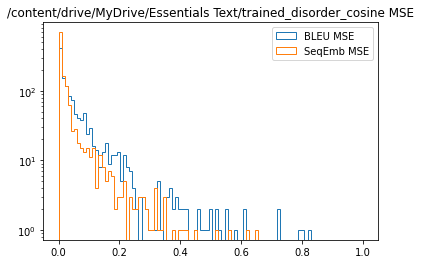

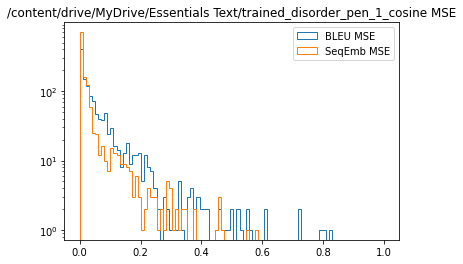

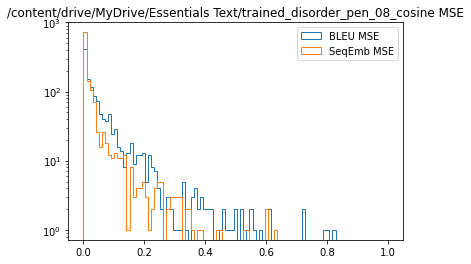

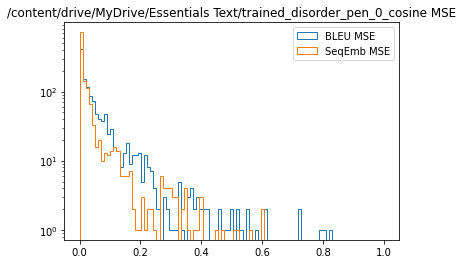

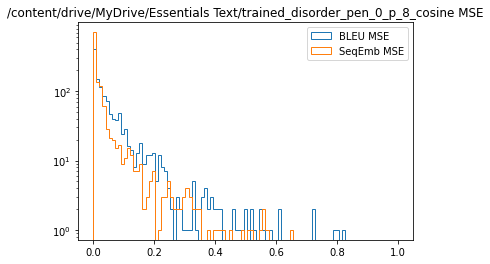

In [67]:
data_base = "/content/drive/MyDrive/Essentials Text/"

exp_params=[
    {
        "only_plot":True,
        "train":False,
        "data_base": "/content/drive/MyDrive/Essentials Text/",
        "model_name": "trained_disorder",
        "similarity": "cosine",
        "disorder_percentage": 0.5, 
        "disorder_cnt": 2, 
        "disorder_swap_dist": 3, 
        "label_penality": 0.04,
    },
    {
        "only_plot":True,
        "train":False,
        "data_base": "/content/drive/MyDrive/Essentials Text/",
        "model_name": "trained_disorder_pen_1",
        "similarity": "cosine",
        "disorder_percentage": 0.5, 
        "disorder_cnt": 2, 
        "disorder_swap_dist": 3, 
        "label_penality": 0.1,
    },
    {
        "only_plot":True,
        "train":False,
        "data_base": "/content/drive/MyDrive/Essentials Text/",
        "model_name": "trained_disorder_pen_08",
        "similarity": "cosine",
        "disorder_percentage": 0.5, 
        "disorder_cnt": 2, 
        "disorder_swap_dist": 3, 
        "label_penality": 0.08,
    },
    {
        "only_plot":True,
        "train":False,
        "data_base": "/content/drive/MyDrive/Essentials Text/",
        "model_name": "trained_disorder_pen_0",
        "similarity": "cosine",
        "disorder_percentage": 0.5, 
        "disorder_cnt": 2, 
        "disorder_swap_dist": 3, 
        "label_penality": 0,
    },
    {
        "only_plot":True,
        "train":False,
        "data_base": "/content/drive/MyDrive/Essentials Text/",
        "model_name": "trained_disorder_pen_0_p_8",
        "similarity": "cosine",
        "disorder_percentage": 0.8, 
        "disorder_cnt": 2, 
        "disorder_swap_dist": 3, 
        "label_penality": 0,
    },
    #  {
    #     "only_plot":False,
    #     "train":True,
    #     "data_base": "/content/drive/MyDrive/Essentials Text/",
    #     "model_name": "trained_original",
    #     "similarity": "cosine",
    #     "disorder_percentage": 0, 
    #     "disorder_cnt": 0, 
    #     "disorder_swap_dist": 0, 
    #     "label_penality": 0,
    # },
    #  {
    #     "only_plot":False,
    #     "train":True,
    #     "data_base": "/content/drive/MyDrive/Essentials Text/",
    #     "model_name": "trained_disorder_pen_0_p_10",
    #     "similarity": "cosine",
    #     "disorder_percentage": 1, 
    #     "disorder_cnt": 2, 
    #     "disorder_swap_dist": 3, 
    #     "label_penality": 0,
    # }   
]

for param in exp_params:
    run(**param)

